In [1]:
%load_ext autoreload
%autoreload 2

from imports import *
from dynamics import *
from model import *

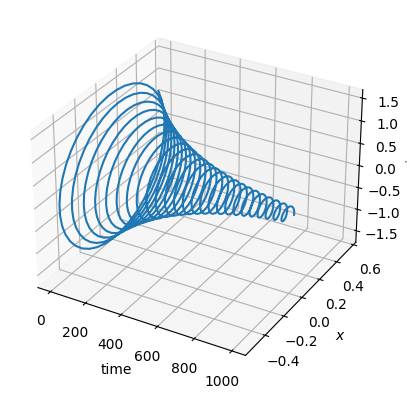

In [2]:
data, dt = dampened_oscillator(m=1.0, c=np.array([0.1]), k=np.array([10.0]), seed=0)

plot_3d(data.cpu().numpy())

In [3]:
def loss_fn(model, batch, num_negative_samples):
    # margin = 2
    # beta = 1

    # '''
    # positive term loss
    # '''
    # # E_x_tp1_positive - E_x_t
    # min_difference = model(batch[1:, :]) - model(batch[:-1, :])

    # positive_loss = torch.mean(torch.maximum(torch.zeros_like(min_difference).cuda(), margin + min_difference)**2)

    # '''
    # negative samples: previous `num_negative_samples` in the trajectory given current x_t (i.e. x_{t - num_negative_samples} ... x_{t-1})
    # '''
    # negative_loss = []

    # for i in range(batch.shape[0]-1):
    #     num_samples = min(i, num_negative_samples)

    #     if num_samples:
    #         # E_x_tp1_negative - E_x_t
    #         max_difference = model(batch[np.random.choice(i, size=(num_samples,), replace=False), :]) - model(batch[i, :].unsqueeze(0)).repeat(num_samples)
            
    #         '''
    #         hinge loss with margin
    #         '''
    #         loss = torch.mean(
    #             torch.maximum(torch.zeros_like(max_difference).cuda(), margin - max_difference)**2
    #         )

    #         '''
    #         Gibbs partition function based loss
    #         '''
    #         # loss = 1/beta * torch.log(torch.sum(torch.exp(-beta * max_difference)))

    #         '''
    #         negative exponential loss
    #         '''
    #         # loss = torch.sum(torch.exp(-max_difference))

    #         negative_loss.append(loss)

    # return positive_loss + sum(negative_loss)/len(negative_loss)

    # '''
    # different way to generate negative samples:
    #     create a hypersphere of radius || E_x_tp1 - E_x_t ||
    #     pick vectors in that hypersphere that are `angle` away from vector E_x_tp1 - E_x_t
    # '''
    # for i in range(batch.shape[0]-1):
    #     E_x_t = model(batch[i, :].unsqueeze(0)).repeat(num_negative_samples)
    #     E_x_tp1 = model(generate_negative_samples(batch[i, :], angle=45, num_samples=num_negative_samples))
    
    #     difference = E_x_tp1 - E_x_t
    #     difference[difference.abs() > 5e-4] = difference
    
    #     loss = torch.sum(torch.maximum(torch.zeros(num_negative_samples).cuda(), margin - (difference))**2)
    #     # loss = 1/beta * torch.log(torch.sum(torch.exp(-beta * (difference))))
    #     # loss = torch.sum(torch.exp(-(difference)))

    #     losses.append(loss)


    min_difference = model(batch[1:, :]) - model(batch[:-1, :])

    '''
    negative samples: previous `num_negative_samples` in the trajectory given current x_t (i.e. x_{t - num_negative_samples} ... x_{t-1})
    '''
    negative_losses = []
    num_negative_samples_per_element = []
    
    for i in range(batch.shape[0]-1):
        num_samples = min(i, num_negative_samples)

        num_negative_samples_per_element.append(num_samples if num_samples else 1)

        if num_samples:
            # E_x_tp1_negative - E_x_t
            max_difference = model(batch[np.random.choice(i, size=(num_samples,), replace=False), :]) - model(batch[i, :].unsqueeze(0)).repeat(num_samples)
            
            negative_loss = torch.sum(
                torch.maximum(torch.zeros_like(max_difference).cuda(), -max_difference)**2 + \
                torch.minimum(torch.zeros_like(max_difference).cuda(), -max_difference/10)
            )

            negative_losses.append(negative_loss)

    '''
    positive term loss
    '''
    # E_x_tp1_positive - E_x_t
    positive_loss = 50 * torch.Tensor(num_negative_samples_per_element).cuda() * \
                    torch.maximum(torch.zeros_like(min_difference).cuda(), min_difference)**2

    return torch.mean(positive_loss) + sum(negative_losses)/len(negative_losses)


def plot_energy_along_trajectory(model, trajectory):
    with torch.no_grad():
        E_x_t = []

        for x_t in trajectory:
            E_x_t.append(model(x_t.unsqueeze(0)).squeeze().detach().cpu().item())

    plt.plot(E_x_t)
    plt.title("energy along trajectory")

    plt.show()


def plot_energy_landscape(model):
    X = torch.linspace(-10, 10, steps=500)
    Y = torch.linspace(-10, 10, steps=500)

    energy_manifold = model(torch.cartesian_prod(X, Y).cuda()).reshape(X.shape[0], Y.shape[0]).detach().cpu().numpy()

    X, Y = np.meshgrid(X.numpy(), Y.numpy())

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    surface = ax.plot_surface(X, Y, energy_manifold, cmap='viridis', edgecolor='k', linewidth=0.5, facecolor=(1,1,1,0.2))

    fig.colorbar(surface, pad=0.1)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$energy$')
    ax.set_title('energy landscape')
    
    plt.show()


def predict(model, data, dt):
    gradients = []
    errors = []
    predicted = []

    x_t = data[0, :]

    for i in range(data.shape[0]-1):
        x_t.requires_grad = True

        E_x_t = model(x_t.unsqueeze(0))
        E_x_t.backward(torch.ones_like(E_x_t).cuda())

        gradients.append(x_t.grad)

        x_tp1_pred = x_t - dt * gradients[-1]

        predicted.append(x_tp1_pred.detach().cpu())
        errors.append(torch.norm(x_tp1_pred.detach() - data[i + 1, :]).cpu().item())

        if (i % 10) == 0:
            x_t = data[i, :]
        else:
            x_t = deepcopy(x_tp1_pred.detach())

    predicted = np.array(torch.stack(predicted))
    errors = np.array(errors)

    plot_3d_trajectory(data.cpu().numpy(), predicted)
    
    return errors


def generate_batch(x, bs):
    i = np.random.randint(0, x.shape[0] - bs + 1, size=(1,)).item()

    return x[i : i + bs, :]


def epoch(iterations, model, optimizer, data, bs, num_negative_samples):
    losses = []

    for i in range(iterations):
        batch = generate_batch(data, bs=bs)

        optimizer.zero_grad()

        loss = loss_fn(model, batch, num_negative_samples=num_negative_samples)

        loss.backward()

        optimizer.step()

        losses.append(loss.detach().cpu().item())

    return np.mean(losses)

  1%|          | 1/100 [00:04<07:24,  4.49s/it]

-0.1404169723391533


  2%|▏         | 2/100 [00:08<07:05,  4.34s/it]

-0.2732391573488712


  3%|▎         | 3/100 [00:12<06:57,  4.30s/it]

-0.23815966993570328


  4%|▍         | 4/100 [00:17<06:50,  4.28s/it]

-0.3771499842405319


  5%|▌         | 5/100 [00:21<06:45,  4.27s/it]

-0.30235899090766905


  6%|▌         | 6/100 [00:25<06:42,  4.29s/it]

-0.19363099336624146


  7%|▋         | 7/100 [00:30<06:36,  4.27s/it]

-0.3731726586818695


  8%|▊         | 8/100 [00:34<06:39,  4.35s/it]

-0.5047220945358276


  9%|▉         | 9/100 [00:39<06:41,  4.41s/it]

-0.4229040652513504


 10%|█         | 10/100 [00:43<06:41,  4.46s/it]

-0.7515641272068023


 11%|█         | 11/100 [00:48<06:39,  4.49s/it]

-0.4998985409736633


 12%|█▏        | 12/100 [00:52<06:38,  4.53s/it]

-0.8486647427082061


 13%|█▎        | 13/100 [00:57<06:35,  4.55s/it]

-0.862296712398529


 14%|█▍        | 14/100 [01:01<06:30,  4.54s/it]

-0.9540181756019592


 15%|█▌        | 15/100 [01:06<06:26,  4.54s/it]

-0.6935353934764862


 16%|█▌        | 16/100 [01:11<06:25,  4.59s/it]

-1.6324016809463502


 17%|█▋        | 17/100 [01:15<06:22,  4.61s/it]

-0.846553111076355


 18%|█▊        | 18/100 [01:20<06:20,  4.64s/it]

-2.0573864936828614


 19%|█▉        | 19/100 [01:25<06:17,  4.66s/it]

-1.5977497100830078


 20%|██        | 20/100 [01:30<06:15,  4.69s/it]

-1.8086233377456664


 21%|██        | 21/100 [01:34<06:10,  4.69s/it]

-2.9380796909332276


 22%|██▏       | 22/100 [01:39<06:05,  4.69s/it]

-2.261538577079773


 23%|██▎       | 23/100 [01:44<06:01,  4.70s/it]

-3.1878509759902953


 24%|██▍       | 24/100 [01:48<05:56,  4.69s/it]

-3.709041452407837


 25%|██▌       | 25/100 [01:53<05:50,  4.68s/it]

-4.891415548324585


 26%|██▌       | 26/100 [01:57<05:42,  4.63s/it]

-3.388837957382202


 27%|██▋       | 27/100 [02:02<05:36,  4.61s/it]

-5.434212970733642


 28%|██▊       | 28/100 [02:07<05:31,  4.61s/it]

-6.877420234680176


 29%|██▉       | 29/100 [02:11<05:27,  4.62s/it]

-6.080104970932007


 30%|███       | 30/100 [02:16<05:24,  4.64s/it]

-8.46654920578003


 31%|███       | 31/100 [02:21<05:19,  4.63s/it]

-7.121322154998779


 32%|███▏      | 32/100 [02:25<05:14,  4.63s/it]

-11.14680118560791


 33%|███▎      | 33/100 [02:30<05:10,  4.63s/it]

-9.482720041275025


 34%|███▍      | 34/100 [02:34<05:06,  4.64s/it]

-11.236236381530762


 35%|███▌      | 35/100 [02:39<05:02,  4.65s/it]

-12.727946186065674


 36%|███▌      | 36/100 [02:44<04:57,  4.64s/it]

-15.448622894287109


 37%|███▋      | 37/100 [02:48<04:53,  4.65s/it]

-13.578044319152832


 38%|███▊      | 38/100 [02:53<04:48,  4.65s/it]

-22.091213607788085


 39%|███▉      | 39/100 [02:58<04:44,  4.66s/it]

-15.507348251342773


 40%|████      | 40/100 [03:02<04:38,  4.65s/it]

-22.064408111572266


 41%|████      | 41/100 [03:07<04:34,  4.66s/it]

-24.26216411590576


 42%|████▏     | 42/100 [03:12<04:29,  4.64s/it]

-11.809553146362305


 43%|████▎     | 43/100 [03:16<04:24,  4.63s/it]

-20.52800178527832


 44%|████▍     | 44/100 [03:21<04:19,  4.64s/it]

-26.512530899047853


 45%|████▌     | 45/100 [03:26<04:14,  4.63s/it]

-30.045328521728514


 46%|████▌     | 46/100 [03:30<04:09,  4.63s/it]

-29.551396560668945


 47%|████▋     | 47/100 [03:35<04:05,  4.63s/it]

-25.636631774902344


 48%|████▊     | 48/100 [03:39<04:00,  4.62s/it]

-37.185302352905275


 49%|████▉     | 49/100 [03:44<03:55,  4.63s/it]

-25.92833023071289


 50%|█████     | 50/100 [03:49<03:51,  4.63s/it]

-34.40553703308105


 51%|█████     | 51/100 [03:53<03:46,  4.63s/it]

-40.31144828796387


 52%|█████▏    | 52/100 [03:58<03:43,  4.65s/it]

-36.6317684173584


 53%|█████▎    | 53/100 [04:03<03:38,  4.64s/it]

-47.44900779724121


 54%|█████▍    | 54/100 [04:07<03:33,  4.64s/it]

-44.24683837890625


 55%|█████▌    | 55/100 [04:12<03:28,  4.64s/it]

-33.95270004272461


 56%|█████▌    | 56/100 [04:17<03:24,  4.66s/it]

-51.175146484375


 57%|█████▋    | 57/100 [04:21<03:19,  4.64s/it]

-50.56605186462402


 58%|█████▊    | 58/100 [04:26<03:15,  4.64s/it]

-54.48416748046875


 59%|█████▉    | 59/100 [04:30<03:09,  4.63s/it]

-35.713797378540036


 60%|██████    | 60/100 [04:35<03:05,  4.63s/it]

-60.523963928222656


 61%|██████    | 61/100 [04:40<02:59,  4.62s/it]

-41.872105026245116


 62%|██████▏   | 62/100 [04:44<02:55,  4.61s/it]

-76.81869354248047


 63%|██████▎   | 63/100 [04:49<02:51,  4.62s/it]

-50.90238037109375


 64%|██████▍   | 64/100 [04:54<02:46,  4.61s/it]

-101.01088104248046


 65%|██████▌   | 65/100 [04:58<02:41,  4.62s/it]

-76.69674224853516


 66%|██████▌   | 66/100 [05:03<02:36,  4.61s/it]

-82.81327438354492


 67%|██████▋   | 67/100 [05:07<02:31,  4.60s/it]

-87.25770263671875


 68%|██████▊   | 68/100 [05:12<02:27,  4.61s/it]

-91.81436614990234


 69%|██████▉   | 69/100 [05:17<02:23,  4.62s/it]

-81.99983749389648


 70%|███████   | 70/100 [05:21<02:19,  4.63s/it]

-95.03055267333984


 71%|███████   | 71/100 [05:26<02:14,  4.63s/it]

-70.95918579101563


 72%|███████▏  | 72/100 [05:31<02:09,  4.63s/it]

-101.55571975708008


 73%|███████▎  | 73/100 [05:35<02:05,  4.64s/it]

-107.26144561767578


 74%|███████▍  | 74/100 [05:40<02:00,  4.64s/it]

-124.79842681884766


 75%|███████▌  | 75/100 [05:45<01:56,  4.66s/it]

-135.22225952148438


 76%|███████▌  | 76/100 [05:49<01:51,  4.66s/it]

-108.93541259765625


 77%|███████▋  | 77/100 [05:54<01:47,  4.67s/it]

-117.1772331237793


 78%|███████▊  | 78/100 [05:59<01:42,  4.66s/it]

-125.57623443603515


 79%|███████▉  | 79/100 [06:03<01:38,  4.67s/it]

-126.51662902832031


 80%|████████  | 80/100 [06:08<01:33,  4.66s/it]

-168.68537445068358


 81%|████████  | 81/100 [06:13<01:28,  4.67s/it]

-104.10315399169922


 82%|████████▏ | 82/100 [06:17<01:23,  4.65s/it]

-142.96105499267577


 83%|████████▎ | 83/100 [06:22<01:18,  4.65s/it]

-109.58819580078125


 84%|████████▍ | 84/100 [06:26<01:14,  4.66s/it]

-162.35284576416015


 85%|████████▌ | 85/100 [06:31<01:09,  4.65s/it]

-124.33988800048829


 86%|████████▌ | 86/100 [06:36<01:05,  4.65s/it]

-210.61163024902345


 87%|████████▋ | 87/100 [06:40<01:00,  4.67s/it]

-158.8512420654297


 88%|████████▊ | 88/100 [06:45<00:55,  4.66s/it]

-216.54332885742187


 89%|████████▉ | 89/100 [06:50<00:51,  4.66s/it]

-152.12188568115235


 90%|█████████ | 90/100 [06:54<00:46,  4.66s/it]

-247.0172882080078


 91%|█████████ | 91/100 [06:59<00:41,  4.66s/it]

-175.09890441894532


 92%|█████████▏| 92/100 [07:04<00:37,  4.68s/it]

4.496759033203125


 93%|█████████▎| 93/100 [07:08<00:32,  4.67s/it]

-149.3327178955078


 94%|█████████▍| 94/100 [07:13<00:27,  4.67s/it]

-134.12041320800782


 95%|█████████▌| 95/100 [07:18<00:23,  4.66s/it]

-125.41444473266601


 96%|█████████▌| 96/100 [07:22<00:18,  4.68s/it]

-156.23238830566407


 97%|█████████▋| 97/100 [07:27<00:14,  4.67s/it]

-147.38187255859376


 98%|█████████▊| 98/100 [07:32<00:09,  4.67s/it]

-219.83526458740235


 99%|█████████▉| 99/100 [07:36<00:04,  4.65s/it]

-221.07484741210936


100%|██████████| 100/100 [07:41<00:00,  4.62s/it]

-259.3823181152344


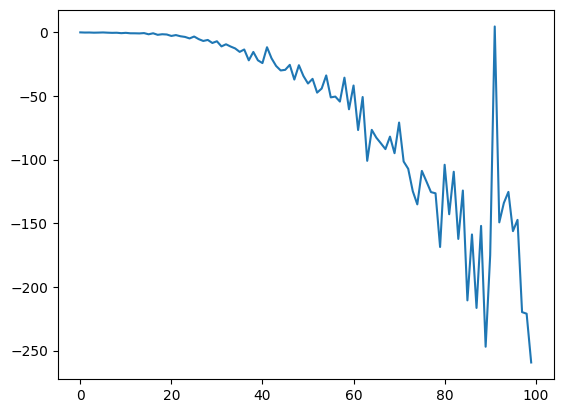

In [4]:
dim = 1

model = EBM(dim * 2).cuda()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

losses = []

seeds = np.arange(10)

for e in tqdm(range(100)):
    data, dt = dampened_oscillator(m=1.0, c=np.array([0.1]), k=np.array([10.0]), 
                                   seed=seeds[torch.randint(0, len(seeds), size=(1,)).item()])

    N = data.shape[0]
    bs = int(0.5 * N)
    
    loss = epoch(iterations=5, model=model, optimizer=optimizer, data=data, bs=bs, num_negative_samples=int(bs * 0.5))
    losses.append(loss)
    print(loss)

plt.plot(losses)

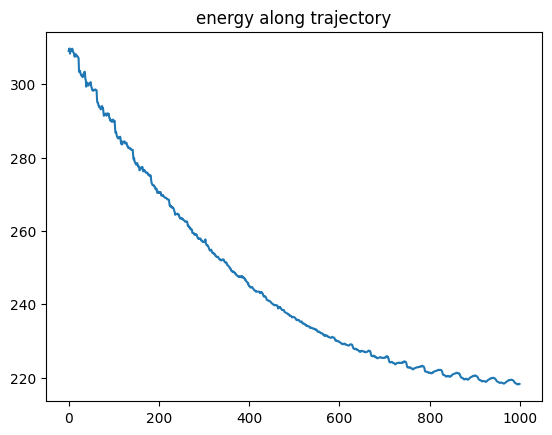

In [10]:
data, dt = dampened_oscillator(m=1.0, c=np.array([0.1]), k=np.array([10.0]), 
                               seed=seeds[torch.randint(0, len(seeds), size=(1,)).item()])

plot_energy_along_trajectory(model, data)

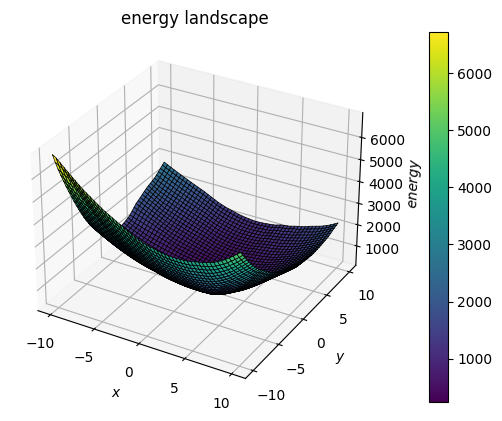

In [6]:
plot_energy_landscape(model)

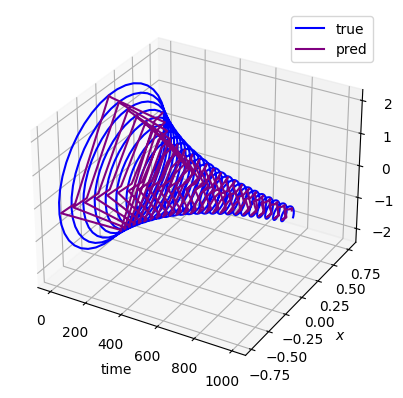

In [7]:
data, dt = dampened_oscillator(m=1.0, c=np.array([0.1]), k=np.array([10.0]), 
                               seed=seeds[torch.randint(0, len(seeds), size=(1,)).item()])

errors = predict(model, data, 0.0001)